# En este módulo se realiza la limpieza de datos y se exportan dentro de este mismo directorio "Clean datasets"

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns


## Carga de data set
Dataset obtenido en http://medata.gov.co/dataset/intento-de-suicidio

Como primera tarea y antes de cargar los datos, fueron borrados manualmente(editor de texto) todos aquellos valores que se presetaran como SD(sin datos) para facilitar el procesado de los datos en siguientes pasos. SD-> null (nan)

Ya cargados los datos se procede a cambiar los titulos del dataset, ya que originalmente todos incluian el nombre de la base de datos, esto con el fin de trabajar con mayor facilidad



In [2]:
# df_suicidio=pd.read_csv("suicidio.csv", delimiter = ';' , dtype = 'string')
df_suicidio=pd.read_csv("suicidio_null.csv", delimiter = ';')
df_suicidio.info()

titles = df_suicidio.columns
arr = []
for i in titles:
    arr.append(i[21:])
    
df_suicidio.columns = arr
df_suicidio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11336 entries, 0 to 11335
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sivigila_intsuicidio.id                  11336 non-null  int64  
 1   sivigila_intsuicidio.semana              11336 non-null  int64  
 2   sivigila_intsuicidio.edad_               11336 non-null  float64
 3   sivigila_intsuicidio.uni_med_            11336 non-null  int64  
 4   sivigila_intsuicidio.sexo_               11336 non-null  object 
 5   sivigila_intsuicidio.nombre_barrio       11336 non-null  object 
 6   sivigila_intsuicidio.comuna              11336 non-null  object 
 7   sivigila_intsuicidio.tipo_ss_            11334 non-null  object 
 8   sivigila_intsuicidio.cod_ase_            11336 non-null  object 
 9   sivigila_intsuicidio.fec_con_            11336 non-null  object 
 10  sivigila_intsuicidio.ini_sin_            11336

,id,semana,edad_,uni_med_,sexo_,nombre_barrio,comuna,tipo_ss_,cod_ase_,fec_con_,...,inmolacion,lanz_vacio,lanz_vehic,lanz_agua,intoxicaci,gp_psiquia,psiquiatri,trab_socia,evento,year_
0,1,49,22.0,1,F,Santo Domingo Savio No.1,Popular,S,CCF002,08/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
1,2,49,19.0,1,M,Villa Hermosa,Villa Hermosa,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
2,3,49,52.0,1,F,Los Conquistadores,Laureles,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
3,4,49,58.0,1,F,Las Violetas,Belen,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
4,5,49,32.0,1,M,Florida Nueva,Laureles,C,EPS010,06/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11331,11332,48,17.0,1,F,Pajarito,Robledo,S,CCF002,05/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11332,11333,48,16.0,1,F,Manrique Central No.1,Aranjuez,P,RES001,30/11/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11333,11334,48,16.0,1,F,Barrios de Jesus,Buenos Aires,C,EPS010,04/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11334,11335,49,23.0,1,F,Moravia,Aranjuez,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015


In [3]:
numeric_cols = df_suicidio.select_dtypes(include=[np.number]).columns.values
print('Numeric cols:' + str(len(numeric_cols)))

non_numeric_cols = df_suicidio.select_dtypes(exclude=[np.number]).columns.values
print('Non numeric cols:' + str(len(non_numeric_cols)))
print(non_numeric_cols)

Numeric cols:42
Non numeric cols:9
['sexo_' 'nombre_barrio' 'comuna' 'tipo_ss_' 'cod_ase_' 'fec_con_'
 'ini_sin_' 'fec_ocurr' 'evento']


## Eliminar columnas no relevantes para el problema
Muy relacionado con las entradas y salidas definidas.
Para este caso no es relevante la forma de intento de suicidio por lo que se eliminaran las columnas ['ahorcamien',arma_corto',arma_fuego',inmolacion',lanz_vacio',lanz_vehic',lanz_agua',intoxicaci'], adicionalmente no son de interes para el problema las columnas ['id','cod_ase_','tip_cas_'] . ['uni_med_', 'evento'] se eliminan ya que solo 1 resgistro tiene un valor diferente  y en el caso del segundo, solo hay un valor posible

In [17]:
for column in df_suicidio.columns:
    print(df_suicidio[column].value_counts())
#     b=aux2[column].str.find('SD').sum();
#     print(str(column) + ':' + str(len(aux2[column])+ b))
#     print(str(column) + ':' + str(b))

2047     1
1338     1
3347     1
1298     1
7441     1
        ..
629      1
2676     1
8817     1
10864    1
2049     1
Name: id, Length: 11336, dtype: int64
38    270
47    267
18    253
14    252
28    250
41    250
39    246
30    243
10    242
36    241
31    236
16    236
12    234
9     233
20    233
35    229
33    228
17    227
32    227
43    227
19    226
42    223
50    221
44    219
13    218
46    218
29    216
34    216
37    214
8     212
15    212
40    211
22    210
23    210
24    210
21    207
51    205
25    205
48    204
7     204
45    203
52    202
49    196
11    195
27    194
5     194
6     191
26    191
3     168
1     167
4     166
2     162
53     22
Name: semana, dtype: int64
15.0    683
17.0    677
16.0    661
14.0    614
18.0    582
       ... 
85.0      2
88.0      2
82.0      2
6.0       1
83.0      1
Name: edad_, Length: 83, dtype: int64
1    11335
2        1
Name: uni_med_, dtype: int64
F     7411
M     3925
Name: sexo_, dtype: int64
SIN INFORMACION

In [15]:
arr

['id',
 'semana',
 'edad_',
 'uni_med_',
 'sexo_',
 'nombre_barrio',
 'comuna',
 'tipo_ss_',
 'cod_ase_',
 'fec_con_',
 'ini_sin_',
 'tip_cas_',
 'pac_hos_',
 'fec_ocurr',
 'inten_prev',
 'intentos',
 'estado_civ',
 'escolarid',
 'prob_parej',
 'enfermedad_cronica',
 'prob_econo',
 'muerte_fam',
 'esco_educ',
 'prob_legal',
 'suici_fm_a',
 'maltr_fps',
 'prob_labor',
 'prob_consu',
 'hist_famil',
 'idea_suici',
 'plan_suici',
 'antec_tran',
 'tran_depre',
 'trast_personalidad',
 'trast_bipolaridad',
 'esquizofre',
 'antec_v_a',
 'abuso_alco',
 'ahorcamien',
 'arma_corto',
 'arma_fuego',
 'inmolacion',
 'lanz_vacio',
 'lanz_vehic',
 'lanz_agua',
 'intoxicaci',
 'gp_psiquia',
 'psiquiatri',
 'trab_socia',
 'evento',
 'year_']

## Datos faltantes

#### Heatmap de datos faltantes
Se observa que desde intento_previo hasta trab_social la cantidad de datos faltantes es muy alta 

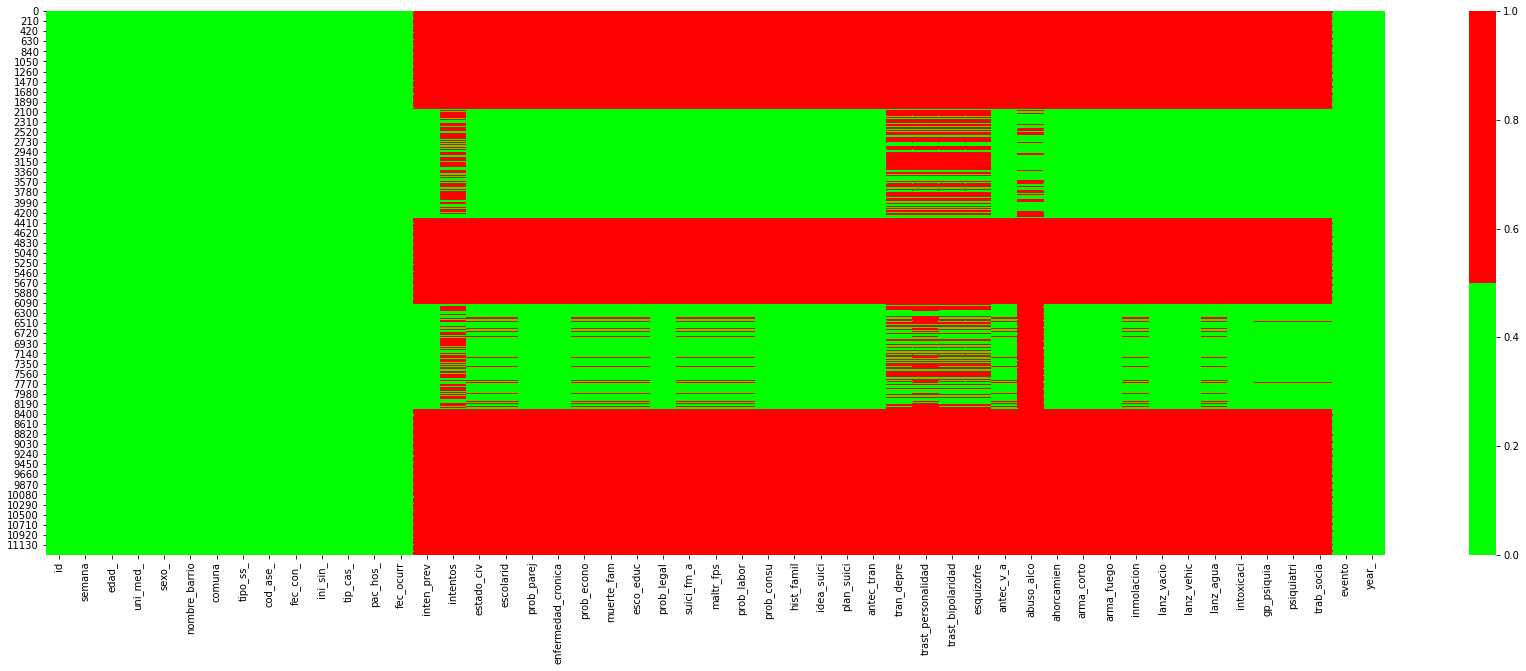

In [4]:
cols = df_suicidio.columns[:]
colours = ['#00FF00', '#ff0000'] # specify the colours - red is missing. green is not missing.
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
sns.heatmap(df_suicidio[cols].isnull(), cmap=sns.color_palette(colours), ax=ax)

#### Porcentaje de datos faltantes

In [13]:
for col in df_suicidio.columns:
    pct_missing = np.mean(df_suicidio[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

tipo_ss_ - 0.02%
pac_hos_ - 0.02%
inten_prev - 60.62%
intentos - 84.99%
estado_civ - 63.36%
escolarid - 63.36%
prob_parej - 60.6%
enfermedad_cronica - 60.6%
prob_econo - 63.36%
muerte_fam - 63.36%
esco_educ - 63.36%
prob_legal - 60.6%
suici_fm_a - 63.36%
maltr_fps - 63.36%
prob_labor - 63.36%
prob_consu - 60.6%
hist_famil - 60.6%
idea_suici - 60.6%
plan_suici - 60.6%
antec_tran - 60.61%
tran_depre - 81.53%
trast_personalidad - 84.38%
trast_bipolaridad - 81.53%
esquizofre - 81.52%
antec_v_a - 63.36%
abuso_alco - 85.41%
ahorcamien - 60.6%
arma_corto - 60.6%
arma_fuego - 60.6%
inmolacion - 63.36%
lanz_vacio - 60.6%
lanz_vehic - 60.6%
lanz_agua - 63.41%
intoxicaci - 60.6%
gp_psiquia - 61.44%
psiquiatri - 61.46%
trab_socia - 61.46%


#### Conteo de registros agrupados por datos faltantes

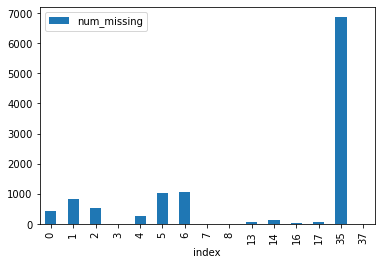

In [6]:
# first create missing indicator for features with missing data
for col in df_suicidio.columns:
    missing = df_suicidio[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
#         print('created missing indicator for: {}'.format(col))
        df_suicidio['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df_suicidio.columns if 'ismissing' in col]
df_suicidio['num_missing'] = df_suicidio[ismissing_cols].sum(axis=1)

df_suicidio['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

## Solucion
### 1. Eliminar registros con 13 o mas datos faltantes
### 2. Tratar columna con alto porcentaje de nulos, ya sea eliminandolas o imputando datos
Se decidio eliminar aquellos registros que presentaran mas de 13 o mas datos faltantes

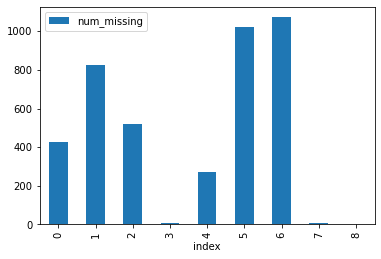

In [7]:
# drop rows with a lot of missing values.
ind_missing = df_suicidio[df_suicidio['num_missing'] >= 13].index
df2 = df_suicidio.drop(ind_missing, axis=0)
# df2.info()
df2['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

# df_filtered = df_suicidio[df_suicidio['fec_ocurr'] != '01/01/1900'] 
# aux2 =df_filtered
# aux2.info()
# aux2['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

In [8]:
df2['num_missing'].value_counts()

6    1072
5    1024
1     827
2     519
0     426
4     273
3       6
7       5
8       2
Name: num_missing, dtype: int64

In [14]:
# df2.info()
for col in df2.columns:
    pct_missing = np.mean(df2[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

inten_prev - 0.05%
intentos - 61.34%
antec_tran - 0.02%
tran_depre - 57.1%
trast_personalidad - 57.37%
trast_bipolaridad - 57.1%
esquizofre - 57.08%
antec_v_a - 0.02%
abuso_alco - 60.18%
lanz_agua - 0.14%
gp_psiquia - 0.14%
psiquiatri - 0.19%
trab_socia - 0.19%


In [11]:
# aux2 = df_suicidio
for column in aux2.columns:
    b=aux2[column].isnull().sum()/len(aux2[column]);
#     b=aux2[column].str.find('SD').sum();
#     print(str(column) + ':' + str(len(aux2[column])+ b))
    print(str(column) + ':' + str(b))

id:0.0
semana:0.0
edad_:0.0
uni_med_:0.0
sexo_:0.0
nombre_barrio:0.0
comuna:0.0
tipo_ss_:0.0
cod_ase_:0.0
fec_con_:0.0
ini_sin_:0.0
tip_cas_:0.0
pac_hos_:0.0
fec_ocurr:0.0
inten_prev:0.00048484848484848484
intentos:0.6126060606060606
estado_civ:0.0
escolarid:0.0
prob_parej:0.0
enfermedad_cronica:0.0
prob_econo:0.0
muerte_fam:0.0
esco_educ:0.0
prob_legal:0.0
suici_fm_a:0.0
maltr_fps:0.0
prob_labor:0.0
prob_consu:0.0
hist_famil:0.0
idea_suici:0.0
plan_suici:0.0
antec_tran:0.00024242424242424242
tran_depre:0.5709090909090909
trast_personalidad:0.5718787878787879
trast_bipolaridad:0.5709090909090909
esquizofre:0.5706666666666667
antec_v_a:0.00024242424242424242
abuso_alco:0.6
ahorcamien:0.0
arma_corto:0.0
arma_fuego:0.0
inmolacion:0.0
lanz_vacio:0.0
lanz_vehic:0.0
lanz_agua:0.0
intoxicaci:0.0
gp_psiquia:0.0014545454545454545
psiquiatri:0.0019393939393939393
trab_socia:0.0019393939393939393
evento:0.0
year_:0.0
tipo_ss__ismissing:0.0
pac_hos__ismissing:0.0
inten_prev_ismissing:0.0
intentos_

In [13]:
# aux2 = aux2.drop(['evento', 'id','uni_med_', 'comuna','tip_cas_'],axis =1)
df_suicidio = aux2


14451


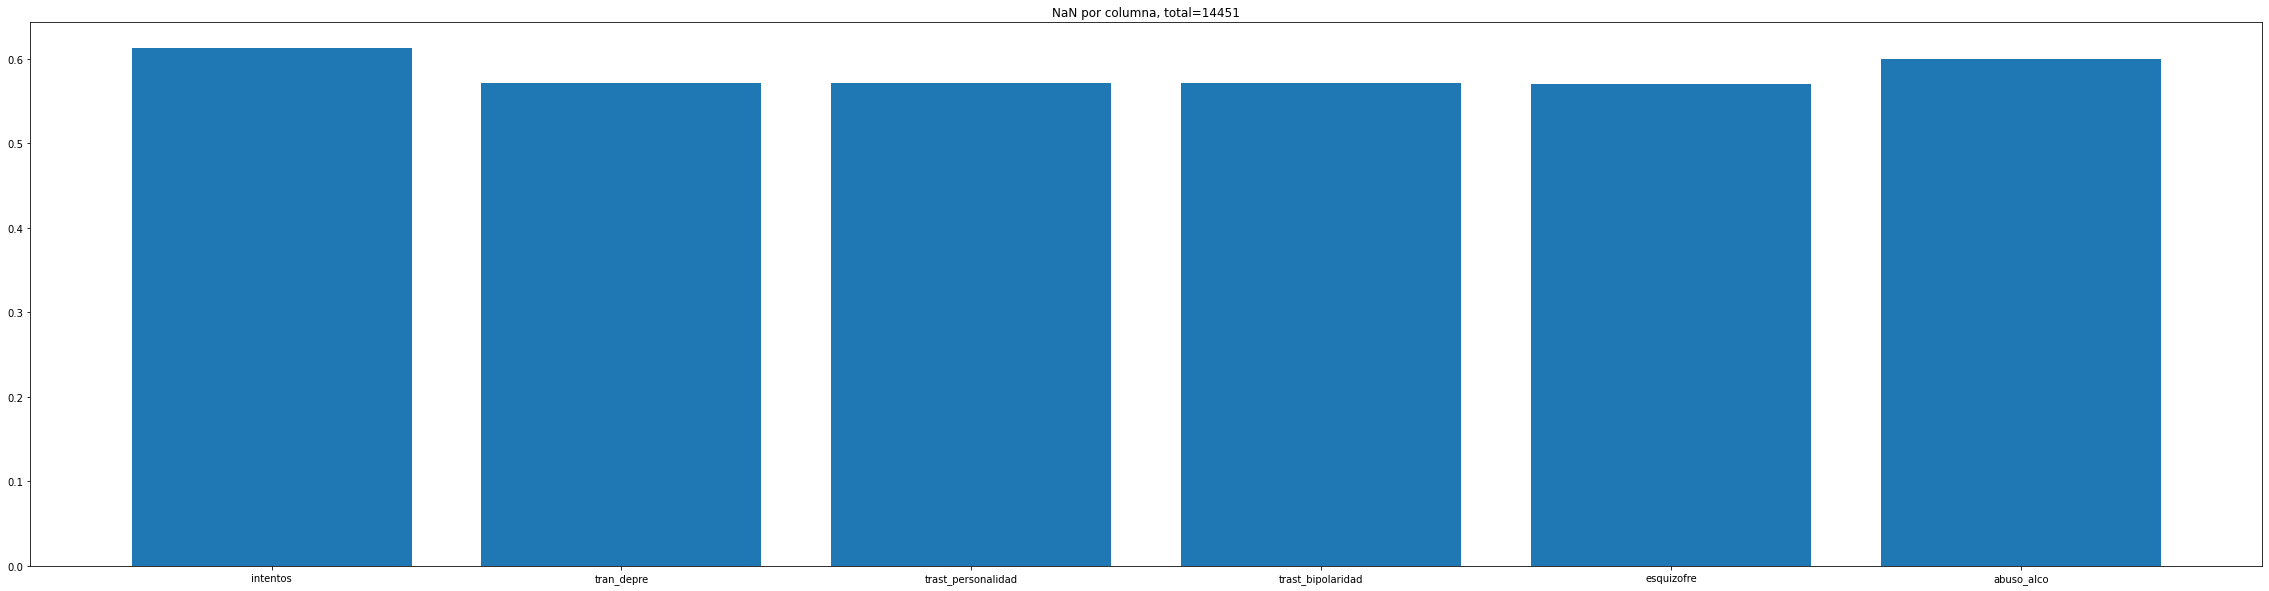

In [14]:
import matplotlib.pyplot as plt
nan_columns = []
nan_values = []

for column in df_suicidio.columns:    
    b=df_suicidio[column].isnull().sum()/df_suicidio.shape[0];
    if b>0.3:
        nan_columns.append(column)
        nan_values.append(b)

fig, ax = plt.subplots(figsize=(40,10))
plt.title('NaN por columna, total='+ str(df_suicidio.isnull().sum().sum()))
plt.bar(nan_columns, nan_values)

print(df_suicidio.isnull().sum().sum())

In [15]:
# df_suicidio['inmolacion'].value_counts()
df_suicidio[['ahorcamien','arma_corto', 'arma_fuego', 'inmolacion', 'lanz_vacio', 'lanz_vehic', 'lanz_agua', 'intoxicaci']]

,ahorcamien,arma_corto,arma_fuego,inmolacion,lanz_vacio,lanz_vehic,lanz_agua,intoxicaci
2048,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
2049,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
2050,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
2051,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
2052,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...
8309,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
8311,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0
8312,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
8313,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0


# Rivera


In [ ]:
from numpy import ones,vstack
from numpy.linalg import lstsq
points = [(2017,1862),(2018,2263)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

In [ ]:
df_aux=pd.read_csv("suicidio2.csv", delimiter = ';')
titles_aux = df_aux.columns
arr_aux = []
for i in titles_aux:
    arr_aux.append(i[21:])

df_aux.columns = arr_aux

In [ ]:
df_aux[['ahorcamien','arma_corto', 'arma_fuego', 'inmolacion', 'lanz_vacio', 'lanz_vehic', 'lanz_agua', 'intoxicaci']]

En esta limpieza también se realiza un primer filtro de características
- "X" e "Y" corresponden a la latitud y longitud de el accidente, dificilmente un accidente pueda ocurrir
en las mismas coordenadas, no se considera util.
- "OBJECTID" Es la clave primaria dentro de una base de datos mongo por lo que no es una carecterística
- "RADICADO" Es un valor único con el que se radicó cada accidente por lo tanto no es relevante
- "FECHA" los datasets ya cuentan con una fecha desglosada en mes y día.
- "MES_NOMBRE" no todas las filas tienen completo este campo, además de que ya se cuenta con una columna "MES" con
el número del mes.
- "DIRECCION_ENC" es otro formato para la dirección, por lo que se puede descartar.

In [ ]:
for i in range(3):
    datalist[i]=datalist[i].drop(['X','Y','OBJECTID', 'RADICADO','FECHA','MES_NOMBRE','DIRECCION_ENC','CBML'],axis=1)

# print(datalist[0].columns)
# a=datalist[0]
# print(a['BARRIO'].unique())# for column in datalist[0].columns:
#     print(column)
#     print(datalist[0][column].unique())


Lo siguiente es verificar la presencia de datos atípicos o mal escritos en las clases
y sean reemplazados manualmente en un archivo csv.


In [ ]:
dataTotal=pd.concat(datalist,axis=0)
# print(dataTotal.columns)
dia_nombre=dataTotal['DIA_NOMBRE'].unique()
clase=dataTotal['CLASE'].unique()
tipo_geocod=dataTotal['TIPO_GEOCOD'].unique()
gravedad=dataTotal['GRAVEDAD'].unique()
barrio=dataTotal['BARRIO'].unique()
comuna=dataTotal['COMUNA'].unique()
mes=dataTotal['MES'].unique()
dia=dataTotal['DIA'].unique()
diseno=dataTotal['DISENO'].unique()
print(barrio)

In [ ]:
dataTotal.to_csv('dataTotal.csv')


La limpieza manual se hizo con la ayuda de una lista de valores únicos en cada columna donde se verificó
uno por uno que estuviera bien escrito y si existían valores que se estuvieran refiriendo a lo mismo como era el
caso de la columna "BARRIO" donde hallámos valores "San Antonio de parado" y "Corregimiento san antonio de prado"
que se referían al mismo pero que al codificarse posteriormente son interpretados conmo distintos.

Una vez que se hizo una limpieza manual de datos de clases mal escritos, cargamos nuevamente el dataset


In [ ]:
dataTotal2=pd.read_csv("dataTotalv2.csv")

Durante la limpieza manual de se omitieron valores atípicos encontrados para las columnas de "BARRIO" y "COMUNA"
donde habían valores como: 'Sin Nombre','0','Inst','AUC1' entre otros para buscar cuántas filas los contenian
y tomar decisiones sobre que hacer con ellos.
Estos datos atípicos tuvieron pocas apareiciones 2 o 3 por cada uno, por lo que se tomó la decisión de eliminar
la fila que los contenía.


In [ ]:
column=['BARRIO','COMUNA']
atypical=[['Sin Nombre','0','Inst','AUC1','6001','9086','7001','9004'],['AU','Sin Inf']]
a=zip(column,atypical)

#borra los datos atípicos de la segunda versión del dataset
for i ,j in a:
    for k in j:
        dataTotal2 = dataTotal2.drop(dataTotal2[dataTotal2[i] ==k].index)

In [ ]:
import matplotlib.pyplot as plt
nan_columns = []
nan_values = []

for column in dataTotal2.columns:
    b=dataTotal2[column].isnull().sum();
    if b>0:
        nan_columns.append(column)
        nan_values.append(b)

fig, ax = plt.subplots(figsize=(10,5))
plt.title('NaN por columna, total='+ str(dataTotal2.isnull().sum().sum()))
plt.bar(nan_columns, nan_values)

print(dataTotal2.isnull().sum().sum())

En el gráfico anterior se aprecian los valores nulos (NaN) por cada columna que los contiene
para un total de 736 que si bien es un número pequeño comparado con el total de datos de 113.659
se optó por rellenarlos en lugar de elimarlos, la estratégia a usar para esto fue la de 'most_frequent' que
por su traducción al español completa con el valor más frecuente en cada columna.

In [ ]:
#datos nulos
from sklearn.impute import SimpleImputer
print(dataTotal2.isnull().sum())
strategy = SimpleImputer(strategy='most_frequent')
dataTotalF=strategy.fit_transform(dataTotal2)
print(dataTotalF)

In [ ]:
newDf = pd.DataFrame(data=dataTotalF, columns=dataTotal2.columns)
print(newDf.isnull().sum())

# El dataset se encuentra sin datos atípicos o extraños.

In [ ]:
newDf.to_csv('cleanData.csv',index=False)

